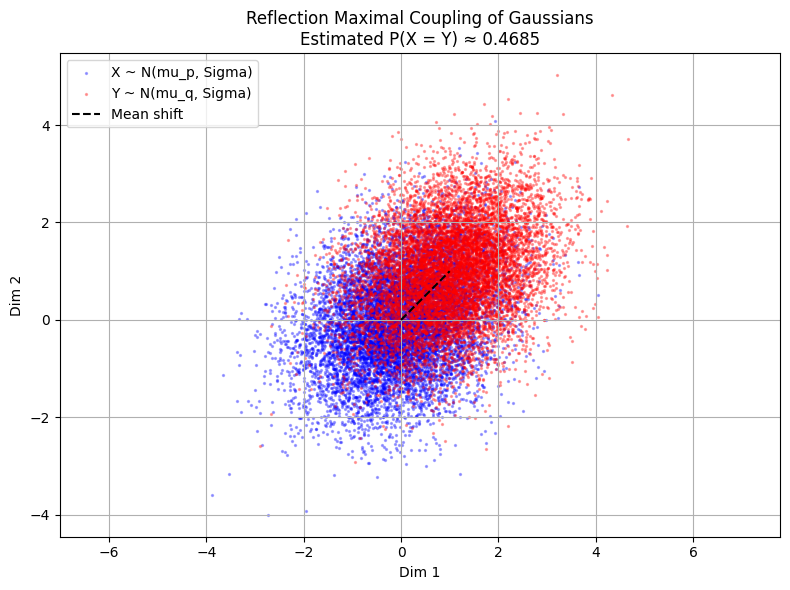

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the two Gaussians
mu_p = np.array([0.0, 0.0])
mu_q = np.array([1.0, 1.0])
Sigma = np.array([[1.0, 0.3], [0.3, 1.0]])  # Shared covariance matrix

# Inverse and Cholesky of Sigma
Sigma_inv = np.linalg.inv(Sigma)
Sigma_sqrt = np.linalg.cholesky(Sigma)

# Compute the coupling
def reflection_maximal_gaussian_coupling(mu_p, mu_q, Sigma, n_samples=10000):
    d = len(mu_p)
    delta = mu_q - mu_p
    delta_norm_sq = delta @ Sigma_inv @ delta
    alpha = np.exp(-0.5 * delta_norm_sq)

    samples_X = []
    samples_Y = []
    matches = 0

    for _ in range(n_samples):
        z = np.random.normal(0, 1, size=d)
        x = mu_p + Sigma_sqrt @ z

        u = np.random.uniform()
        if u < alpha:
            y = mu_q + Sigma_sqrt @ z
            matches += 1
        else:
            reflect_z = z - 2 * ((z @ (Sigma_inv @ delta)) / delta_norm_sq) * delta
            y = mu_q + Sigma_sqrt @ reflect_z

        samples_X.append(x)
        samples_Y.append(y)

    samples_X = np.array(samples_X)
    samples_Y = np.array(samples_Y)
    return samples_X, samples_Y, matches / n_samples

# Generate samples
samples_X, samples_Y, prob_match = reflection_maximal_gaussian_coupling(mu_p, mu_q, Sigma)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(samples_X[:, 0], samples_X[:, 1], s=2, alpha=0.3, label='X ~ N(mu_p, Sigma)', color='blue')
plt.scatter(samples_Y[:, 0], samples_Y[:, 1], s=2, alpha=0.3, label='Y ~ N(mu_q, Sigma)', color='red')
plt.plot([mu_p[0], mu_q[0]], [mu_p[1], mu_q[1]], 'k--', label='Mean shift')
plt.title(f'Reflection Maximal Coupling of Gaussians\nEstimated P(X = Y) ≈ {prob_match:.4f}')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


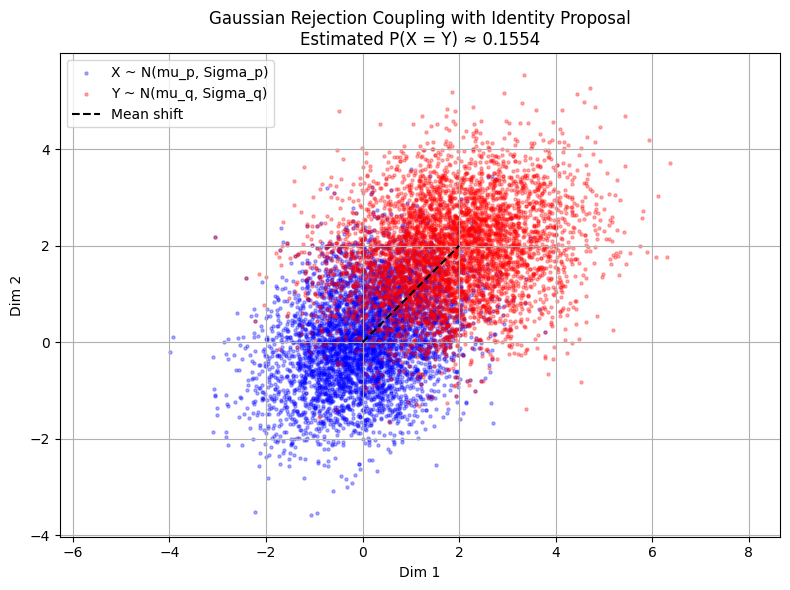

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv, eigvals, det

mu_p = np.array([0.0, 0.0])
mu_q = np.array([2.0, 2.0])

Sigma_p = np.array([[1.0, 0.3], [0.3, 1.0]])
Sigma_q = np.array([[1.5, 0.2], [0.2, 1.0]])

lambda_max = max(np.max(np.linalg.eigvals(Sigma_p)), np.max(np.linalg.eigvals(Sigma_q))) # As evoked in the article I take \Sigma_max that way.
Sigma_hat = lambda_max * np.eye(2)

proposal_mean = mu_p

# Compute M_p and M_q from determinant ratios, formula of the article
M_p = np.sqrt(det(Sigma_hat) / det(Sigma_p))
M_q = np.sqrt(det(Sigma_hat) / det(Sigma_q))

# Gaussian distributions
mv_p = multivariate_normal(mean=mu_p, cov=Sigma_p) # The ones we want to couple
mv_q = multivariate_normal(mean=mu_q, cov=Sigma_q)
mv_hat = multivariate_normal(mean=proposal_mean, cov=Sigma_hat) # Proposal

def gaussian_rejection_coupling():
    while True:
        z = mv_hat.rvs()
        u = np.random.uniform()

        w_p = mv_p.pdf(z) / mv_hat.pdf(z)
        w_q = mv_q.pdf(z) / mv_hat.pdf(z)

        if u < min(w_p / M_p, w_q / M_q):
            return z, z  # Coupled sample
        else:
            x = mv_p.rvs()
            y = mv_q.rvs()
            return x, y  # Independent fallback

n_samples = 5000
samples_X = []
samples_Y = []
coupled = 0

for _ in range(n_samples):
    x, y = gaussian_rejection_coupling()
    samples_X.append(x)
    samples_Y.append(y)
    if np.allclose(x, y, atol=1e-6):
        coupled += 1

samples_X = np.array(samples_X)
samples_Y = np.array(samples_Y)

plt.figure(figsize=(8, 6))
plt.scatter(samples_X[:, 0], samples_X[:, 1], alpha=0.3, label='X ~ N(mu_p, Sigma_p)', color='blue', s=5)
plt.scatter(samples_Y[:, 0], samples_Y[:, 1], alpha=0.3, label='Y ~ N(mu_q, Sigma_q)', color='red', s=5)
plt.plot([mu_p[0], mu_q[0]], [mu_p[1], mu_q[1]], 'k--', label='Mean shift')
plt.title(f"Gaussian Rejection Coupling with Identity Proposal\nEstimated P(X = Y) ≈ {coupled / n_samples:.4f}")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

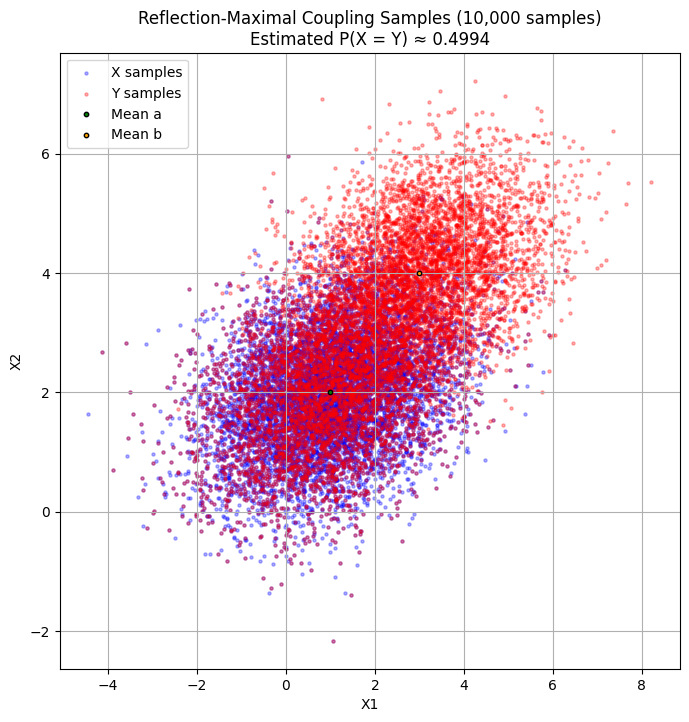

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def reflection_coupling(a, b, Sigma):
    Sigma_inv_sqrt = np.linalg.inv(np.linalg.cholesky(Sigma))  # Inverse square root of covariance matrix
    z = np.dot(Sigma_inv_sqrt, a - b)
    
    e = z / np.linalg.norm(z)
    
    X = np.random.randn(len(a))  # X ~ N(0, I)
    U = np.random.rand()  # U ~ U(0, 1)
    
    if np.random.normal(0, 1) * U < np.random.normal(0, 1) * np.dot(X + z, X + z):
        Y = X + z
    else:
        Y = X - 2 * np.dot(e, X) * e
    
    X_final = a + np.dot(np.linalg.cholesky(Sigma), X)
    Y_final = b + np.dot(np.linalg.cholesky(Sigma), Y)
    
    return X_final, Y_final

# Example usage:
np.random.seed(42)  # For reproducibility

a = np.array([1, 2])  # Example point a
b = np.array([3, 4])  # Example point b
Sigma = np.array([[2, 0.5], [0.5, 1]])  # Example covariance matrix

# Generate samples
num_samples = 10000
samples_X = []
samples_Y = []
coupled = 0

for _ in range(num_samples):
    X_sample, Y_sample = reflection_coupling(a, b, Sigma)
    samples_X.append(X_sample)
    samples_Y.append(Y_sample)
    if np.allclose(X_sample, Y_sample, atol=1e-6):
        coupled += 1

samples_X = np.array(samples_X)
samples_Y = np.array(samples_Y)

# Visualization
plt.figure(figsize=(8, 8))
plt.scatter(samples_X[:, 0], samples_X[:, 1], color='blue', alpha=0.3, label='X samples', s=5)
plt.scatter(samples_Y[:, 0], samples_Y[:, 1], color='red', alpha=0.3, label='Y samples', s=5)
plt.scatter(a[0], a[1], color='green', label='Mean a', s=10, edgecolors='black', zorder=5)
plt.scatter(b[0], b[1], color='orange', label='Mean b', s=10, edgecolors='black', zorder=5)
plt.legend()
plt.title(f"Reflection-Maximal Coupling Samples (10,000 samples)\nEstimated P(X = Y) ≈ {coupled / num_samples:.4f}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()
